# Split with DecisionTree

## Load Balrog-Bagpipes catalog

In [1]:
import pickle

In [2]:
file = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/balrog-bagpipes.pkl'
data = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of Balrog-Bagpipes catalog: {len(data)}')

Length of Balrog-Bagpipes catalog: 2417437


In [3]:
data = data.dropna(subset=['stell_best', 'ssfr_best'])
print(f'Length of Balrog-Bagpipes catalog (no nan): {len(data)}')

Length of Balrog-Bagpipes catalog (no nan): 2417396


In [4]:
for i in range(4):
    print(f'Length of Balrog-Bagpipes Bin{i}: {len(data[data["bin"]==i])}')

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


## Crate training sample

In [5]:
from plot_utils import *
import nz_utils as nz

In [6]:
data['z_mean'] = np.zeros(len(data))
pzc_array = np.vstack(data['pzc_weighted']) 
#data['z_mean'] = np.apply_along_axis(nz.mean_z, axis=1, arr=pzc_array)
data['z_mean'] = np.apply_along_axis(nz.median_z, axis=1, arr=pzc_array) # Median works better

In [7]:
pz_bin = np.array([
    np.mean(data['pzc_weighted'][data['bin'] == i], axis=0)
    for i in range(4)
])
pz_bin_pileup = np.array([nz.pile_up(pz) for pz in pz_bin])

bin_width = 0.01
z = np.linspace(0, 6.0, len(pz_bin[0]))
z3 = np.linspace(0, 2.99, len(pz_bin_pileup[0]))
dz = np.append(np.diff(z), bin_width)
dz3 = np.append(np.diff(z3), bin_width)

def smooth_and_normalize(pz, z_grid, dz_grid):
    smoothed = nz.remove_spikes_savgol(z_grid, pz)
    return nz.pz_normalization(dz_grid, smoothed)

pz_bin_pileup_smooth = np.array([smooth_and_normalize(pz, z3, dz3) for pz in pz_bin_pileup])

z_mean_bin = np.array([nz.mean_z(pz) for pz in pz_bin])
z_mean_pileup = np.array([nz.mean_z(pz) for pz in pz_bin_pileup])
z_mean_pileup_smooth = np.array([nz.mean_z(pz) for pz in pz_bin_pileup_smooth])

In [8]:
stell_mean = [np.mean(data['stell_best'][data['bin']==i]) for i in range(4)]
ssfr_mean = [np.mean(data['ssfr_best'][data['bin']==i]) for i in range(4)]

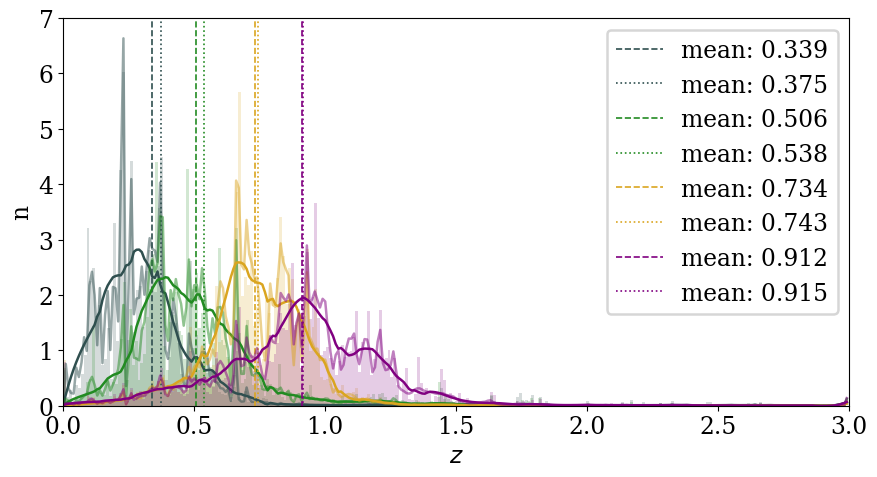

In [48]:
fig = plt.figure(figsize=(9, 5))
ax = fig.gca()

for i in range(4):
    ax.plot(z3, pz_bin_pileup[i], alpha=0.5, color=colors_bin[i])
    ax.plot(z3, pz_bin_pileup_smooth[i], color=colors_bin[i])
    plot_vline(ax, z_mean_pileup_smooth[i], color=colors_bin[i], label='mean: '+'{:.3f}'.format(z_mean_pileup_smooth[i]))

    plt.hist(data['z_mean'][data['bin']==i], bins=400, density=True, alpha=0.2, color=colors_bin[i])
    plot_vline(ax, np.mean(data['z_mean'][data['bin']==i]), color=colors_bin[i], ls=':', 
               label='mean: '+'{:.3f}'.format(np.mean(data['z_mean'][data['bin']==i])))

axis_settings(ax, z_params)
ax.legend()

plt.tight_layout()
fig.patch.set_alpha(1.0)
fig.savefig('figures/nzs_hist_full2.png', dpi=200, bbox_inches='tight')
plt.show()

In [22]:
def assign_labels_training(data_bin, n_zbin):

    training_label = np.ones(data_bin['z_mean'].size)*(-1)
            
    z_percentiles = np.linspace(0, 100, n_zbin)
    z_edges = np.percentile(data_bin['z_mean'], z_percentiles)
    
    z_edges = z_edges[np.where(z_edges!=0)]
    z_edges = np.insert(z_edges, 0, 0)
    
    if z_edges[-1]!=np.max(data_bin['z_mean']):
        z_edges = np.insert(z_edges, -1, )
    n = len(z_edges)
    
    for i in range(0, n-1):
        z_low, z_high = z_edges[i], z_edges[i + 1]
        epsilon = data_bin.loc[(data_bin['z_mean'] >= z_low) & (data_bin['z_mean'] <= z_high)]
        
        p = np.linspace(0, 100, 3)
        prop_edges = np.percentile(epsilon['stell_best'], p)
        prop_edges[0] = np.min(epsilon['stell_best'])
        prop_edges[2] = np.max(epsilon['stell_best'])
        
        for j in range(2):
            prop_low = prop_edges[j]
            prop_high = prop_edges[j+1]
            training_label[(data_bin['z_mean'] >= z_low) & (data_bin['z_mean'] <= z_high) 
                         & (data_bin['stell_best'] >= prop_low) & (data_bin['stell_best'] <= prop_high)] = j
    
    assert len(np.where(training_label==-1)[0]) == 0
    
    unique, counts = np.unique(training_label, return_counts=True)
    assert abs(counts[0] - counts[1])/counts[0] < 1 # sub-bins are same size

    return training_label.reshape(-1,1)

n_values = [700, 800, 900, 1000]  

def ensemble_training_labels(data_bin, n_values):
    results = []

    for n in n_values:
        labels = assign_labels_training(data_bin, n)
        results.append(labels.flatten())  # flatten so it's 1D

    results = np.array(results)  # shape: (len(n_values), num_samples)
    
    # Majority vote across all labelings
    final_labels = np.round(results.mean(axis=0)).astype(int)
    return final_labels.reshape(-1, 1)

In [43]:
data['label'] = np.ones(len(data['bin']))*(-1)

for i in range(4):
    bin_i = data[data['bin']==i]
    print(f'Length of Balrog-Bagpipes Bin{i}: ' + str(len(bin_i)))

    training_label = assign_labels_training(bin_i, 1000)
    #training_label = ensemble_training_labels(bin_i, n_values)
    data.loc[data['bin'] == i, 'label'] = training_label

assert len(np.where(data['label']==-1)[0]) == 0

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


### Plot training sample

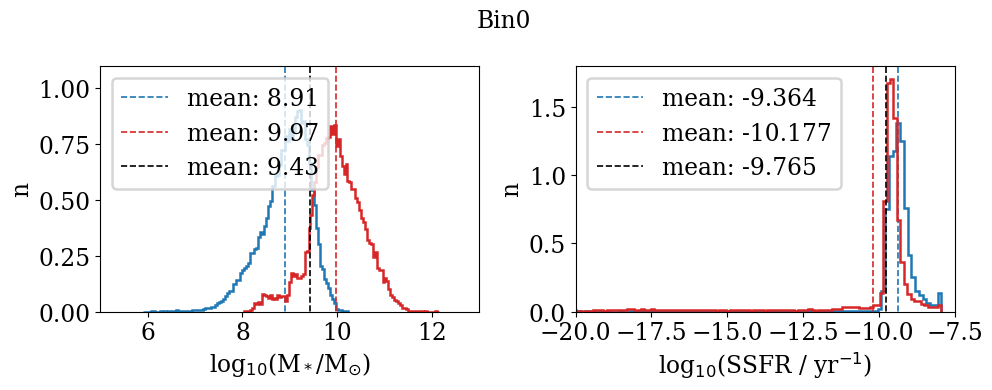

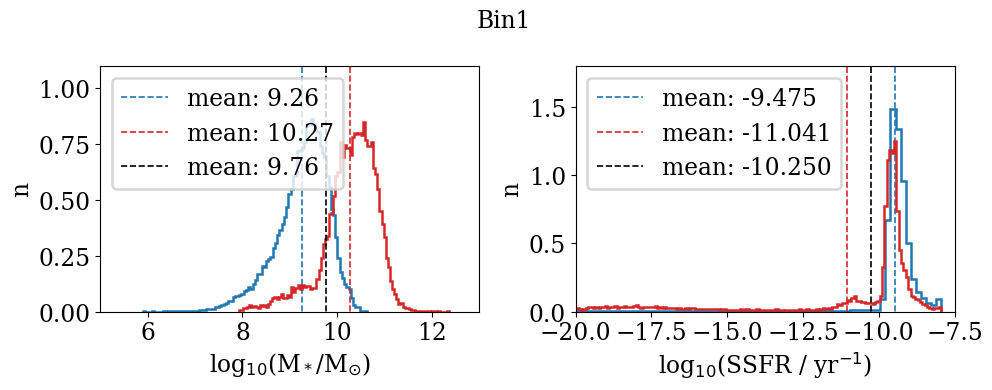

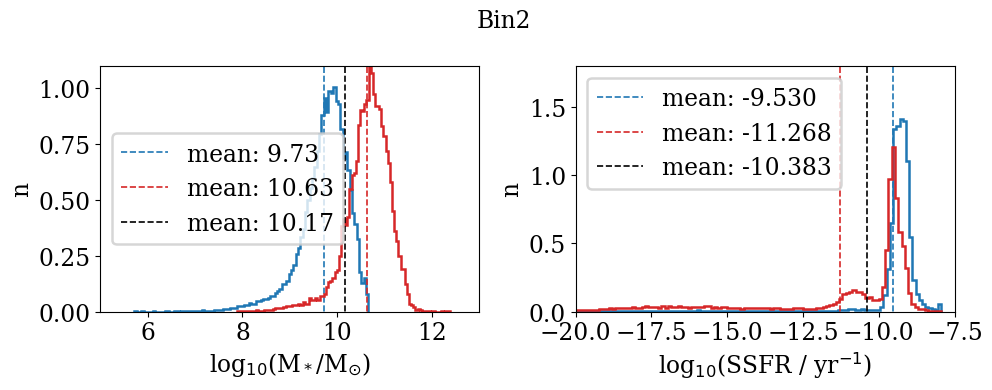

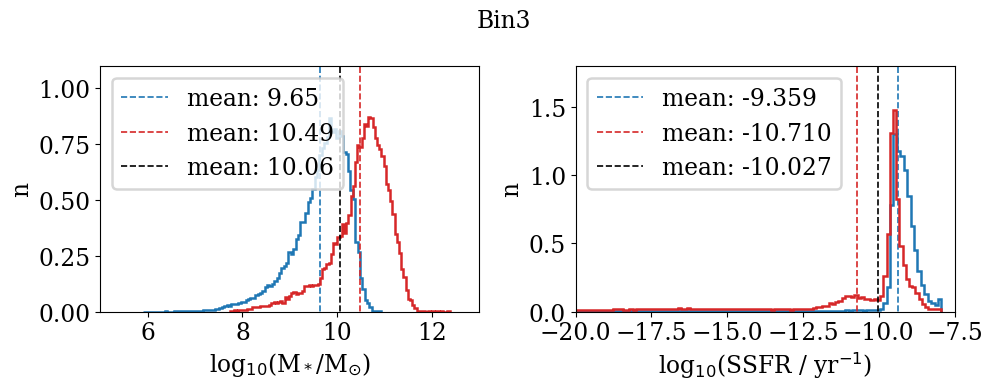

In [49]:
for i in range(4):
    fig = plt.figure(figsize=(10, 4))
    bin_i = data[data['bin']==i]
    plt.suptitle(f'Bin{i}')
    
    ax1 = plt.subplot(1,2,1)
    for j in range(2):
        ax1.hist(bin_i['stell_best'][bin_i['label']==j], bins=100, histtype='step', density=True, color=colors_stell_bin[j])
        plot_vline(ax1, np.mean(bin_i['stell_best'][bin_i['label']==j]), color=colors_stell_bin[j], 
                   label='mean: '+'{:.2f}'.format(np.mean(bin_i['stell_best'][bin_i['label']==j])))
    plot_vline(ax1, stell_mean[i], label='mean: '+'{:.2f}'.format(stell_mean[i]))
    axis_settings(ax1, stell_params)
    ax1.set_ylim(0, 1.1)
    ax1.legend()

    ax2 = plt.subplot(1,2,2)
    for j in range(2):
        ax2.hist(bin_i['ssfr_best'][bin_i['label']==j], bins=500, histtype='step', density=True, color=colors_stell_bin[j])
        plot_vline(ax2, np.mean(bin_i['ssfr_best'][bin_i['label']==j]), color=colors_stell_bin[j], 
                   label='mean: '+'{:.3f}'.format(np.mean(bin_i['ssfr_best'][bin_i['label']==j])))
    plot_vline(ax2, ssfr_mean[i], label='mean: '+'{:.3f}'.format(ssfr_mean[i]))
    axis_settings(ax2, ssfr_params)
    ax2.set_ylim(0, 1.8)
    ax2.legend()

    plt.tight_layout()
    fig.patch.set_alpha(1.0)
    fig.savefig(f'figures/stell_ssfr_hist_bin{i}.png', dpi=200, bbox_inches='tight')
    plt.show()

dz:        0.020
dz (mean): 0.010
calib dz:  0.015


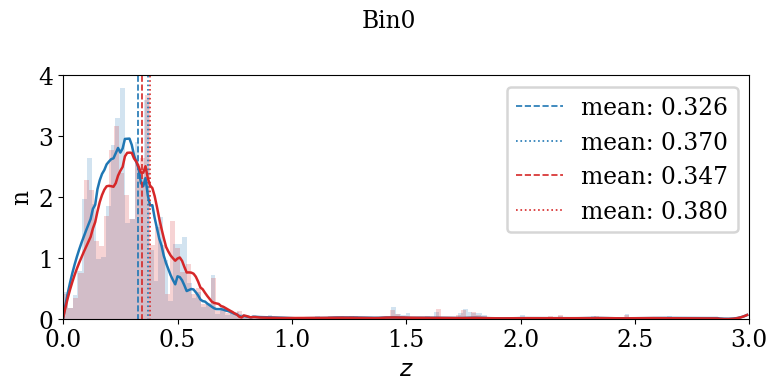

dz:        0.001
dz (mean): 0.010
calib dz:  0.011


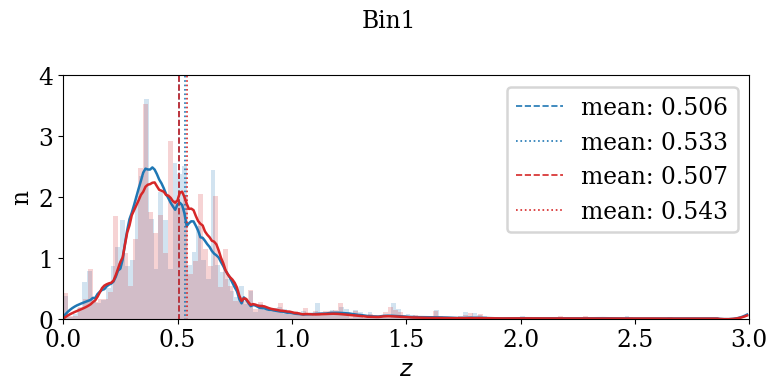

dz:        0.011
dz (mean): 0.004
calib dz:  0.008


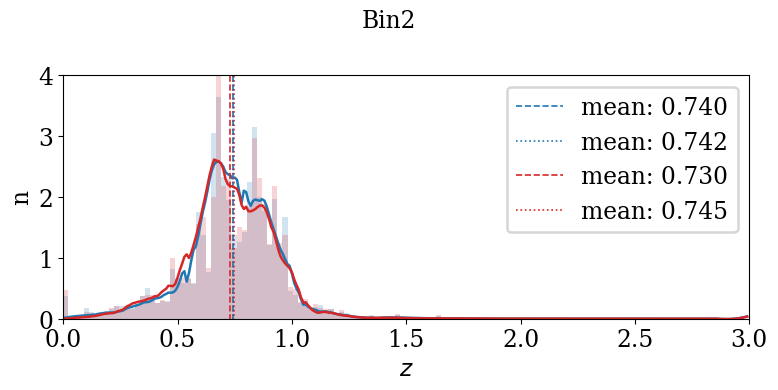

dz:        0.015
dz (mean): 0.006
calib dz:  0.015


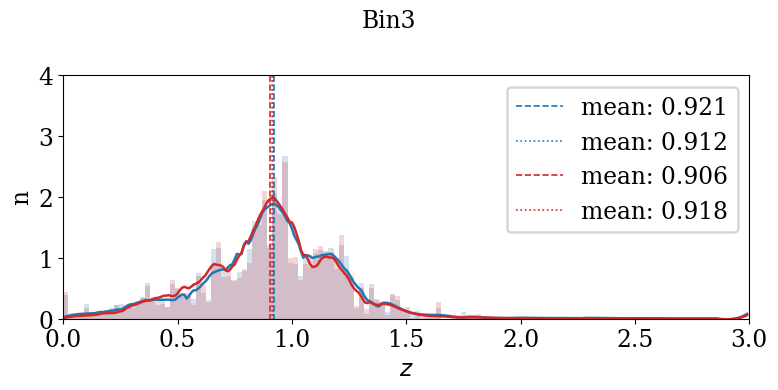

In [51]:
for i in range(4):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.gca()
    bin_i = data[data['bin']==i]
    plt.suptitle(f'Bin{i}')

    pz_bin_i = np.array([np.mean(bin_i['pzc_weighted'][bin_i['label'] == i], axis=0) for i in range(2)])
    pz_bin_i_pileup = np.array([nz.pile_up(pz_bin_i[i]) for i in range(2)])
    pz_bin_i_pileup_smooth = np.array([smooth_and_normalize(pz_bin_i_pileup[i], z3, dz3) for i in range(2)])
    meanz_bin_i_pileup_smooth = np.array([nz.mean_z(pz_bin_i_pileup_smooth[i]) for i in range(2)])

    for j in range(2):
        ax.plot(z3, pz_bin_i_pileup_smooth[j], color=colors_stell_bin[j])
        plot_vline(ax, meanz_bin_i_pileup_smooth[j], color=colors_stell_bin[j], 
                   label='mean: '+'{:.3f}'.format(meanz_bin_i_pileup_smooth[j]))
        ax.hist(bin_i['z_mean'][bin_i['label']==j], bins=200, alpha=0.2, density=True, color=colors_stell_bin[j])
        plot_vline(ax, np.mean(bin_i['z_mean'][bin_i['label']==j]), color=colors_stell_bin[j], ls=':',
                   label='mean: '+'{:.3f}'.format(np.mean(bin_i['z_mean'][bin_i['label']==j])))
    
    print('dz:       ', '{:.3f}'.format(np.abs(meanz_bin_i_pileup_smooth[0]-meanz_bin_i_pileup_smooth[1])))
    print('dz (mean):', '{:.3f}'.format(np.abs(np.mean(bin_i['z_mean'][bin_i['label']==0]) - np.mean(bin_i['z_mean'][bin_i['label']==1]))))
    print('calib dz: ', nz.dz_calib[i])

    axis_settings(ax, z_params)
    ax.set_ylim(0, 4)
    plt.legend()
    
    plt.tight_layout()
    fig.patch.set_alpha(1.0)
    plt.savefig(f'figures/nz_hist_bin{i}.png', dpi=200, bbox_inches='tight')
    plt.show()